alpha, beta, K: 0.5 100 7
Acc, nmi, adj: 0.7005169867060561 0.5227127535166938 0.4658499491717587
SIL: 0.20430464


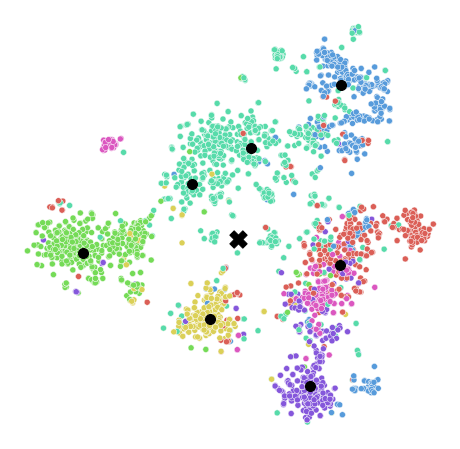

In [1]:
"Implementation based on https://github.com/PetarV-/DGI"

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn

from models import GIC, LogReg
from utils import process


from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import statistics 
import argparse

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn import metrics
from munkres import Munkres, print_matrix
import numpy as np
from sklearn.cluster import KMeans

from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.metrics import silhouette_score

class clustering_metrics():
    "from https://github.com/Ruiqi-Hu/ARGA"
    def __init__(self, true_label, predict_label):
        self.true_label = true_label
        self.pred_label = predict_label


    def clusteringAcc(self):
        # best mapping between true_label and predict label
        l1 = list(set(self.true_label))
        numclass1 = len(l1)

        l2 = list(set(self.pred_label))
        numclass2 = len(l2)
        if numclass1 != numclass2:
            print('Class Not equal, Error!!!!')
            return 0

        cost = np.zeros((numclass1, numclass2), dtype=int)
        for i, c1 in enumerate(l1):
            mps = [i1 for i1, e1 in enumerate(self.true_label) if e1 == c1]
            for j, c2 in enumerate(l2):
                mps_d = [i1 for i1 in mps if self.pred_label[i1] == c2]

                cost[i][j] = len(mps_d)

        # match two clustering results by Munkres algorithm
        m = Munkres()
        cost = cost.__neg__().tolist()

        indexes = m.compute(cost)

        # get the match results
        new_predict = np.zeros(len(self.pred_label))
        for i, c in enumerate(l1):
            # correponding label in l2:
            c2 = l2[indexes[i][1]]

            # ai is the index with label==c2 in the pred_label list
            ai = [ind for ind, elm in enumerate(self.pred_label) if elm == c2]
            new_predict[ai] = c

        acc = metrics.accuracy_score(self.true_label, new_predict)
        f1_macro = metrics.f1_score(self.true_label, new_predict, average='macro')
        precision_macro = metrics.precision_score(self.true_label, new_predict, average='macro')
        recall_macro = metrics.recall_score(self.true_label, new_predict, average='macro')
        f1_micro = metrics.f1_score(self.true_label, new_predict, average='micro')
        precision_micro = metrics.precision_score(self.true_label, new_predict, average='micro')
        recall_micro = metrics.recall_score(self.true_label, new_predict, average='micro')
        return acc, f1_macro, precision_macro, recall_macro, f1_micro, precision_micro, recall_micro

    def evaluationClusterModelFromLabel(self):
        nmi = metrics.normalized_mutual_info_score(self.true_label, self.pred_label)
        adjscore = metrics.adjusted_rand_score(self.true_label, self.pred_label)
        acc, f1_macro, precision_macro, recall_macro, f1_micro, precision_micro, recall_micro = self.clusteringAcc()

        
        return acc, nmi, adjscore


cuda0 = torch.cuda.is_available()#False

dataset = 'cora'

#num_clusters = 32
# training params
batch_size = 1
nb_epochs = 2000
patience = 20
lr = 0.001
l2_coef = 0.0
drop_prob = 0.0
hid_units = 64
sparse = True
nonlinearity = 'prelu' 

         
torch.cuda.empty_cache()


for m in range(1):
    
    
    adj, features, labels, idx_train, idx_val, idx_test = process.load_data(dataset)
    
    adj_sparse = adj
    
    ylabels = labels
    ylabelsx = np.where(labels == 1)[0]
    _, tsne_lab =  np.where(ylabels==1)
    
    
    features, _ = process.preprocess_features(features)


    nb_nodes = features.shape[0]
    ft_size = features.shape[1]
    nb_classes = labels.shape[1]


    adj = process.normalize_adj(adj + sp.eye(adj.shape[0]))

    if sparse:
        sp_adj = process.sparse_mx_to_torch_sparse_tensor(adj)
    else:
        adj = (adj + sp.eye(adj.shape[0])).todense()

    features = torch.FloatTensor(features[np.newaxis])
    if not sparse:
        adj = torch.FloatTensor(adj[np.newaxis])
    labels = torch.FloatTensor(labels[np.newaxis])
    #idx_train = torch.LongTensor(idx_train)
    #idx_val = torch.LongTensor(idx_val)
    #idx_test = torch.LongTensor(idx_test)

    if cuda0:
        #print('Using CUDA')
        features = features.cuda()
        if sparse:
            sp_adj = sp_adj.cuda()
        else:
            adj = adj.cuda()
        labels = labels.cuda()
        #idx_train = idx_train.cuda()
        #idx_val = idx_val.cuda()
        #idx_test = idx_test.cuda()

    b_xent = nn.BCEWithLogitsLoss()
    b_bce = nn.BCELoss()
    xent = nn.CrossEntropyLoss()
    cnt_wait = 0
    best = 1e9
    best_t = 0

    
    
    for alpha in [0.5] :
        for  beta in [100]:
            for num_clusters in [nb_classes]:
                
                print('alpha, beta, K:',alpha,beta, num_clusters)

                model = GIC(nb_nodes,ft_size, hid_units, nonlinearity, num_clusters, beta)
                optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)
                cnt_wait = 0
                best = 1e9
                best_t = 0
                if cuda0:
                #print('Using CUDA')
                    model.cuda()
                for epoch in range(nb_epochs):
                    model.train()
                    optimiser.zero_grad()

                    idx = np.random.permutation(nb_nodes)
                    shuf_fts = features[:, idx, :]

                    lbl_1 = torch.ones(batch_size, nb_nodes)
                    lbl_2 = torch.zeros(batch_size, nb_nodes)
                    lbl = torch.cat((lbl_1, lbl_2), 1)

                    

                    if cuda0:
                        shuf_fts = shuf_fts.cuda()
                        lbl = lbl.cuda()
                        

                    logits, logits2  = model(features, shuf_fts, sp_adj if sparse else adj, sparse, None, None, None, beta) 

                    loss = alpha *b_xent(logits, lbl)  +  (1-alpha)*b_xent(logits2, lbl) 

                    if loss < best:
                        best = loss
                        best_t = epoch
                        cnt_wait = 0
                        torch.save(model.state_dict(), dataset+'.pkl')

                        
                    else:
                        cnt_wait += 1

                    if cnt_wait == patience:
                        #print('Early stopping!')
                        break

                    loss.backward()
                    optimiser.step()

                    
                model.load_state_dict(torch.load(dataset+'.pkl'))

                
                embeds, H,c, Z= model.embed(features, sp_adj if sparse else adj, sparse, None, beta)
                embs = embeds[0, :]
                embs = embs / embs.norm(dim=1)[:, None]
                
                kmeans = KMeans(n_clusters=nb_classes).fit(embs[ylabelsx].cpu().detach().numpy())
                predict_labels = kmeans.predict(embs[ylabelsx].cpu().detach().numpy())
            
                cm = clustering_metrics(tsne_lab, predict_labels)
                acc, nmi, adjscore = cm.evaluationClusterModelFromLabel()
                
                
                print('Acc, nmi, adj:', acc, nmi, adjscore)
                
                
                tsne = TSNE(n_components=2, perplexity=40, n_iter=1000)
                tsne_results = tsne.fit_transform(embs.cpu().detach().numpy())
                """
                plt.figure(figsize=(8,8))
                g = sns.scatterplot(
                    x=tsne_results[:,0], y=tsne_results[:,1],
                    hue=tsne_lab,
                    palette=sns.color_palette("hls", 7),
                    alpha=0.3,
                    legend=None
                )
                #g.set_ylim(-20,20)
                #g.set_xlim(-20,20)
                plt.axis('off')
                plt.show()
                
                """
                
                
                print('SIL:', silhouette_score(tsne_results[ylabelsx], tsne_lab))

                

                Z2 = torch.cat((c,Z),dim=0)
                H2 = torch.cat((embs,Z2),dim=0)
                tsne_lab2 = tsne_lab
                for _ in range(num_clusters+1):
                    tsne_lab2 = np.append(tsne_lab2, nb_classes)

                tsne = TSNE(n_components=2, perplexity=40, n_iter=1000)
                tsne_results = tsne.fit_transform(H2.cpu().detach().numpy())
                plt.figure(figsize=(8,8))
                g = sns.scatterplot(
                    x=tsne_results[:nb_nodes,0], y=tsne_results[:nb_nodes,1],
                    hue=tsne_lab,
                    palette=sns.color_palette("hls", nb_classes),
                    alpha=1,
                    legend=None
                )
                plt.scatter(x = tsne_results[nb_nodes:nb_nodes+1,0], y=tsne_results[nb_nodes:nb_nodes+1,1], s=300, marker='X', color='black')
                if (alpha != 1):
                    plt.scatter(x = tsne_results[nb_nodes+1:,0], y=tsne_results[nb_nodes+1:,1],s=100, color='black')
                #g.set_ylim(-20,20)
                #g.set_xlim(-20,20)
                plt.axis('off')
                plt.show()

